## Visualize interrater results

- [ ] get code for loading results for a particular dataset
- [ ] examine the way the code worked for the main paper and copy the structure, it should make taking the plots easier.
- [ ] think about ways to visualize the pixelwise results, maybe just load it and get the plots in a single notebook for expediency.

#### Loading all the spreadsheet data

In [29]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from natsort import natsorted
from tqdm import tqdm

In [23]:
out_domain_results = os.listdir("./results/")

In [24]:
out_domain_results = [i for i in out_domain_results if ".csv" in i]

In [25]:
#out_domain_results

In [26]:
UNCERTAINTY_TYPES = {
    "SEnt",
    "MC-Drop",
    "Ens",
    "Evid",
    "Ind",
    "P-Unet",
    "SSN",
    "SSN-Ens",
}

In [31]:
def convert_files_to_large_df(folder, filenames, excluded_rows = [], dataset_name="mss3"):
    dfs = []
    for fn in tqdm(natsorted(filenames)):
        if dataset_name not in fn:
            continue
        df = pd.read_csv(os.path.join(folder, fn))
        if "_evid_" in fn:
            uncertainty_type = "Evid"
        elif "_deterministic_" in fn:
            uncertainty_type = "SEnt"
        elif "_ind_" in fn:
            uncertainty_type = "Ind"
        elif "_punet_" in fn:
            uncertainty_type = "P-Unet"
        elif "_ens" in fn and "ssn" not in fn:
            uncertainty_type = "Ens"
        elif "_mc_drop" in fn:
            uncertainty_type = "MC-Drop"
        elif "_ssn_ens_" in fn:
            uncertainty_type = "SSN-Ens"
        elif "_ssn_" in fn and "_ens" not in fn:
            uncertainty_type = "SSN"
        else:
            print("uncertainty type unclear for ", fn)
            continue
            
        cv_fold = fn.split("_")[-2][-1]
        
        df['uncertainty_type'] = [uncertainty_type for _ in range(len(df))]
        df['cv_fold'] = [cv_fold for _ in range(len(df))]
        if len(excluded_rows) > 0:
            df = df.drop(index=excluded_rows, inplace=False)
        
        dfs.append(df)
    
    return pd.concat(dfs, ignore_index=False)

In [33]:
mss3_df = convert_files_to_large_df("results/", out_domain_results, dataset_name="mss3")
lbc_df = convert_files_to_large_df("results/", out_domain_results, dataset_name="lbc")
challenge_df = convert_files_to_large_df("results/", out_domain_results, dataset_name="challenge")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 810/810 [00:02<00:00, 292.04it/s]


In [37]:
pd.set_option('display.float_format',
      lambda x: '{:,.3f}'.format(x) if abs(x) < 10000 else '{:,.0f}'.format(x))

### 95% confidences

In [36]:
from scipy.stats import t as t_distribution
def mean_and_95_conf_over_cvfold(df, metric, return_sem=True):
    cv_scores = df.groupby(['uncertainty_type', 'cv_fold'])[metric].mean().groupby('uncertainty_type')
    mean = cv_scores.mean().rename(f"{metric} mean", axis='index')
    std = cv_scores.std(ddof=1)
    size = cv_scores.size()
    sem_value = std / (np.sqrt(size))
    
    confidence_level = 0.95
    degrees_of_freedom = size - 1
    margin_of_error = t_distribution.ppf((1 + confidence_level) / 2, degrees_of_freedom) * sem_value
    margin_of_error = margin_of_error.rename(f"{metric} 95%")
    sem_value  = sem_value.rename(f"{metric} 95%")
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)
    
    if return_sem:
        return pd.concat([mean, sem_value], axis=1)#, confidence_interval[0], confidence_interval[1]], axis=1)
    else:
        return pd.concat([mean, margin_of_error], axis=1)

### increasing samples plots

In [52]:
SAMPLING_UNCERTAINTY_TYPES = {
    "MC-Drop",
    # "Ens",
    "Ind",
    "P-Unet",
    "SSN",
    "SSN-Ens",
}

In [53]:
import matplotlib.cm as cm 
cmap = cm.Set2
UNCERTAINTY_COLOURS = {
    'Ens':cmap(0),
    'Evid':cmap(1),
    'Ind':cmap(2),
    'MC-Drop':cmap(3),
    'P-Unet':cmap(4),
    'SEnt':cmap(5),
    'SSN':cmap(6),
    'SSN-Ens':cmap(7),
}

In [54]:
from collections import defaultdict
from scipy.stats import t as t_distribution


In [55]:
def plot_metric_as_samples_increase(df, metric, ylabel, title, dolegend):
    metric_vals = {}
    sample_nums = [2,3,5,7,10,15,20,25,30]

    dataset_averages = df.groupby(['uncertainty_type', 'cv_fold'])[[f'{metric}_ss{s}' for s in sample_nums]].mean().groupby(['uncertainty_type'])
    mean_score = dataset_averages.mean()
    std = dataset_averages.std()
    size = 6#dataset_averages.size()

    sem_value = std / (np.sqrt(size))
    confidence_level = 0.95
    degrees_of_freedom = size - 1
    # margin_of_error = t_distribution.ppf((1 + confidence_level) / 2, degrees_of_freedom) * sem_value

    for key in SAMPLING_UNCERTAINTY_TYPES:

        # plt.plot(sample_nums, mean_score.loc[key].values, '--', alpha=0.7, color=UNCERTAINTY_COLOURS[key])
        plt.scatter(sample_nums, mean_score.loc[key].values, label=key, zorder=3, color=UNCERTAINTY_COLOURS[key])
        plt.errorbar(sample_nums, mean_score.loc[key].values, yerr= sem_value.loc[key].values,
                     color=UNCERTAINTY_COLOURS[key], capsize=5, linestyle='--', linewidth=2)
    
    if dolegend:
        plt.legend(loc='upper right');

    plt.xlabel("Number of Samples")
    plt.ylabel(ylabel)
    
    # plt.legend(['Line']) 
    plt.title(title)

    # Specify which grid lines  
    plt.grid(axis='both', linestyle='--', linewidth=0.5) 
    
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    

In [56]:
mss3_df.keys()

Index(['Unnamed: 0', 'rater0_sample_top_dice', 'rater0_sample_best_avd',
       'rater1_sample_top_dice', 'rater1_sample_best_avd', 'GED_vol_sorted',
       'UIRO_curves_t0.00', 'JUEO_curves_t0.00', 'UIRO_curves_t0.01',
       'JUEO_curves_t0.01',
       ...
       'vds_rater1_sample27', 'vds_rater_mean_sample27', 'vds_rater0_sample28',
       'vds_rater1_sample28', 'vds_rater_mean_sample28', 'vds_rater0_sample29',
       'vds_rater1_sample29', 'vds_rater_mean_sample29',
       'rater0_best_dice_dsorted_ss30', 'rater1_best_dice_dsorted_ss30'],
      dtype='object', length=545)

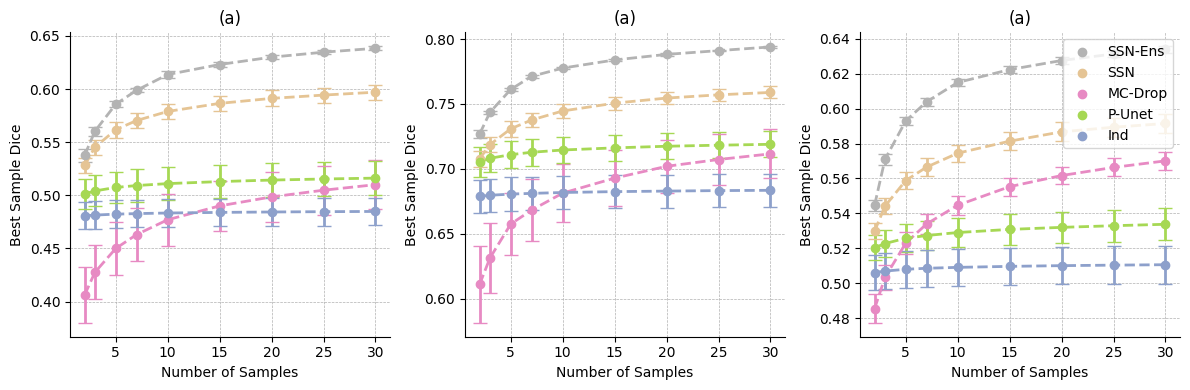

In [63]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(mss3_df, "rater0_best_dice_dsorted", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(lbc_df, "rater0_best_dice_dsorted", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(challenge_df, "rater0_best_dice_dsorted", r"Best Sample Dice", "(a)", True)
plt.tight_layout()

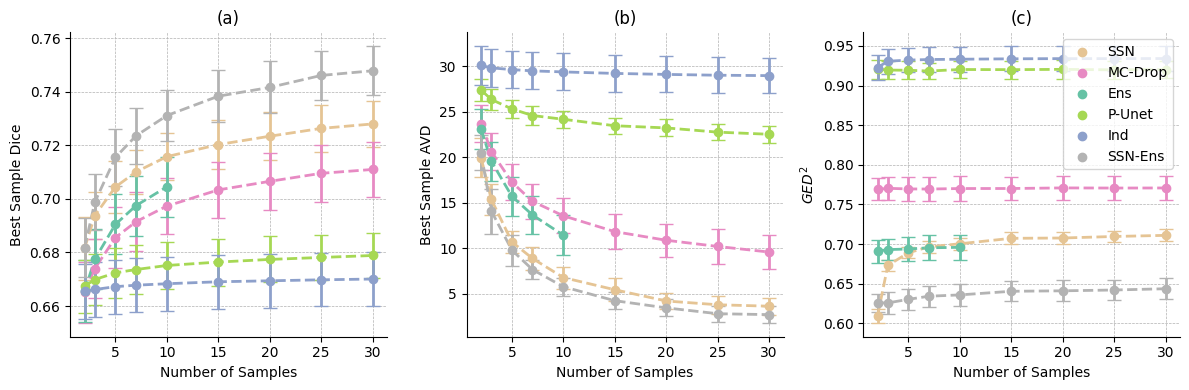

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_metric_as_samples_increase(in_domain_df, "best_dice_dsorted", r"Best Sample Dice", "(a)", False)
plt.subplot(1,3,2)
plot_metric_as_samples_increase(in_domain_df, "best_avd", r"Best Sample AVD", "(b)", False)
plt.subplot(1,3,3)
plot_metric_as_samples_increase(in_domain_df, "GED^2", r"$GED^2$", "(c)", True)

plt.tight_layout()
plt.savefig("plots_output/increasing_sample_num_plot.pdf", bbox_inches="tight")